<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [100]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [101]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [102]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [103]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [104]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [105]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            # nn.Flatten(),
            # nn.LazyLinear(10),
            nn.Conv2d(1, 10, kernel_size=20, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [106]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [107]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [108]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 1

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [109]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [110]:
from torchsummary import summary
model = Module().to(device)
summary(model, (1, 28, 28))

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 10, 5, 5]           4,010
              ReLU-2             [-1, 10, 5, 5]               0
 AdaptiveAvgPool2d-3             [-1, 10, 1, 1]               0
           Flatten-4                   [-1, 10]               0
            Linear-5                   [-1, 10]             110
Total params: 4,120
Trainable params: 4,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
Task 0 Start!
Epoch	1	Acc:  0.4636, Loss:  0.0068
Epoch	2	Acc:  0.8005, Loss:  0.0031
Epoch	3	Acc:  0.8481, Loss:  0.0022
Epoch	4	Acc:  0.8694, Loss:  0.0019
Epoch	5	Acc:  0.8815, Loss:  0.0016
Epoch	6	Acc:  0.8899, Loss:  0.0015
Epoch	7	

 - Task 0

Accuracy 0.3517
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.72      0.85      0.78       980
     1 - one       0.33      0.00      0.01      1135
     2 - two       0.25      0.11      0.15      1032
   3 - three       0.51      0.04      0.08      1010
    4 - four       0.17      0.69      0.28       982
    5 - five       0.52      0.60      0.56       892
     6 - six       0.36      0.93      0.52       958
   7 - seven       0.94      0.04      0.09      1028
   8 - eight       0.63      0.24      0.35       974
    9 - nine       0.29      0.13      0.18      1009

    accuracy                           0.35     10000
   macro avg       0.47      0.36      0.30     10000
weighted avg       0.47      0.35      0.29     10000



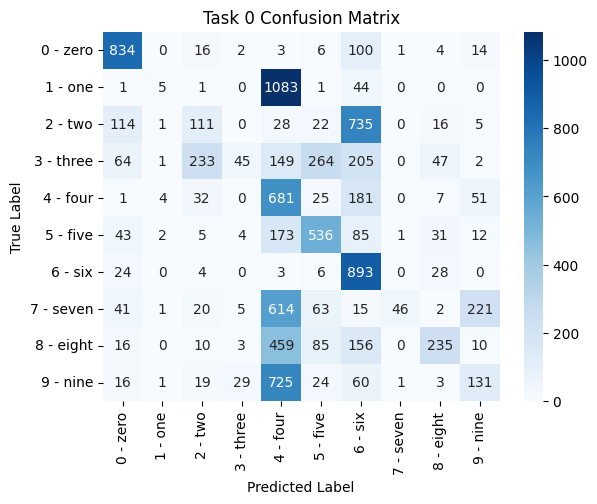

In [111]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.7607
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.87      0.91      0.89       980
     1 - one       0.84      0.89      0.87      1135
     2 - two       0.79      0.81      0.80      1032
   3 - three       0.74      0.71      0.73      1010
    4 - four       0.72      0.74      0.73       982
    5 - five       0.59      0.54      0.56       892
     6 - six       0.75      0.66      0.71       958
   7 - seven       0.80      0.79      0.80      1028
   8 - eight       0.74      0.71      0.73       974
    9 - nine       0.71      0.79      0.75      1009

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



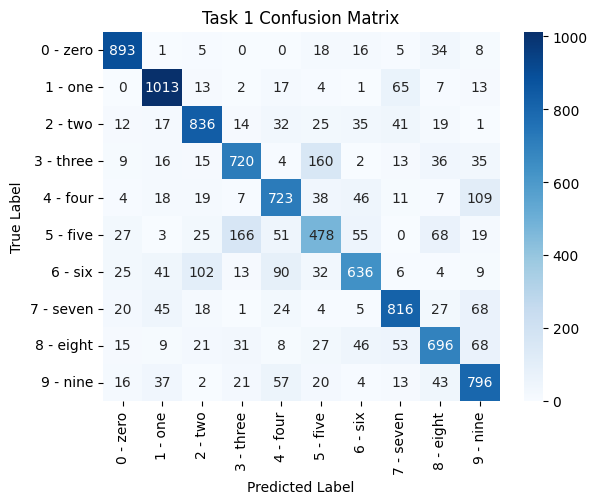

In [112]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.0.weight
torch.Size([10, 1, 20, 20])
Max fisher is 0.05839 and it's parameter diff is 0.02123
Min Parameter diff is 1.86371 and it's fisher is 0.00004
fisher > parameter diff: 67
fisher <= parameter diff: 333


<Figure size 640x480 with 0 Axes>

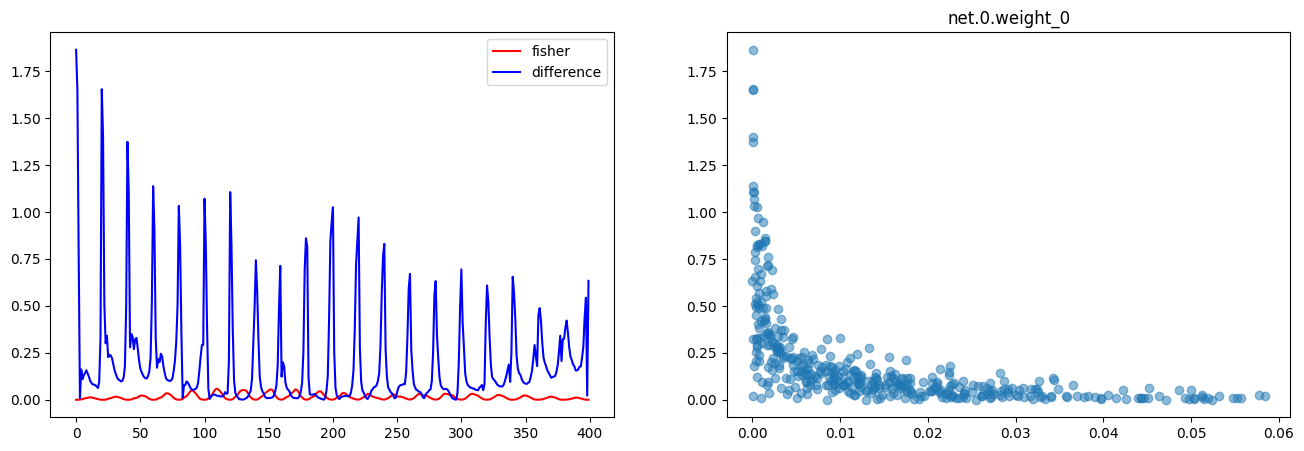

Max fisher is 0.03904 and it's parameter diff is 0.01055
Min Parameter diff is 0.70241 and it's fisher is 0.00099
fisher > parameter diff: 35
fisher <= parameter diff: 365


<Figure size 640x480 with 0 Axes>

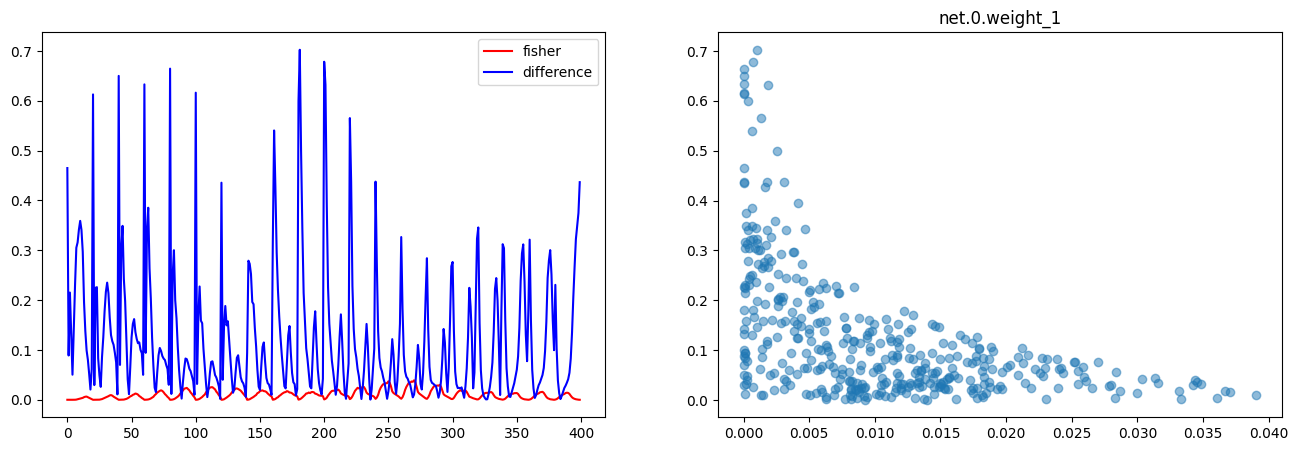

Max fisher is 0.22077 and it's parameter diff is 0.01691
Min Parameter diff is 0.36215 and it's fisher is 0.00656
fisher > parameter diff: 259
fisher <= parameter diff: 141


<Figure size 640x480 with 0 Axes>

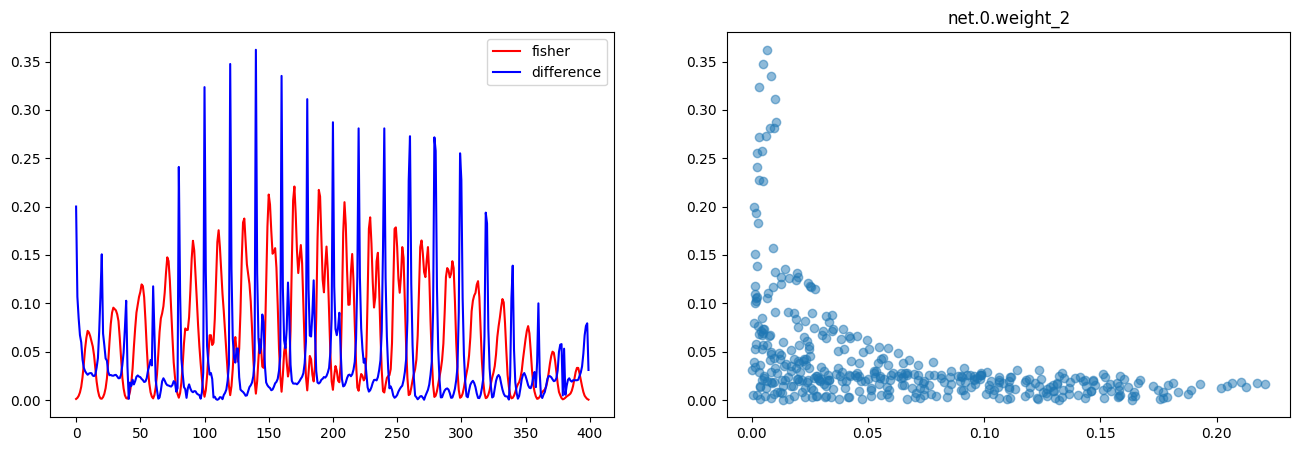

Max fisher is 0.00584 and it's parameter diff is 0.18033
Min Parameter diff is 1.06982 and it's fisher is 0.00008
fisher > parameter diff: 1
fisher <= parameter diff: 399


<Figure size 640x480 with 0 Axes>

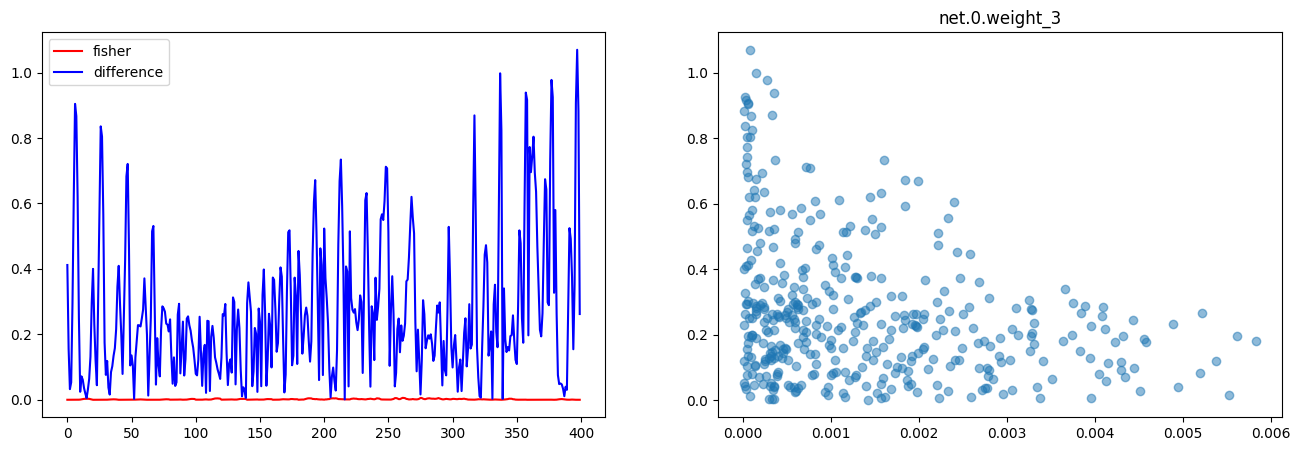

Max fisher is 0.22441 and it's parameter diff is 0.02043
Min Parameter diff is 1.08331 and it's fisher is 0.00043
fisher > parameter diff: 199
fisher <= parameter diff: 201


<Figure size 640x480 with 0 Axes>

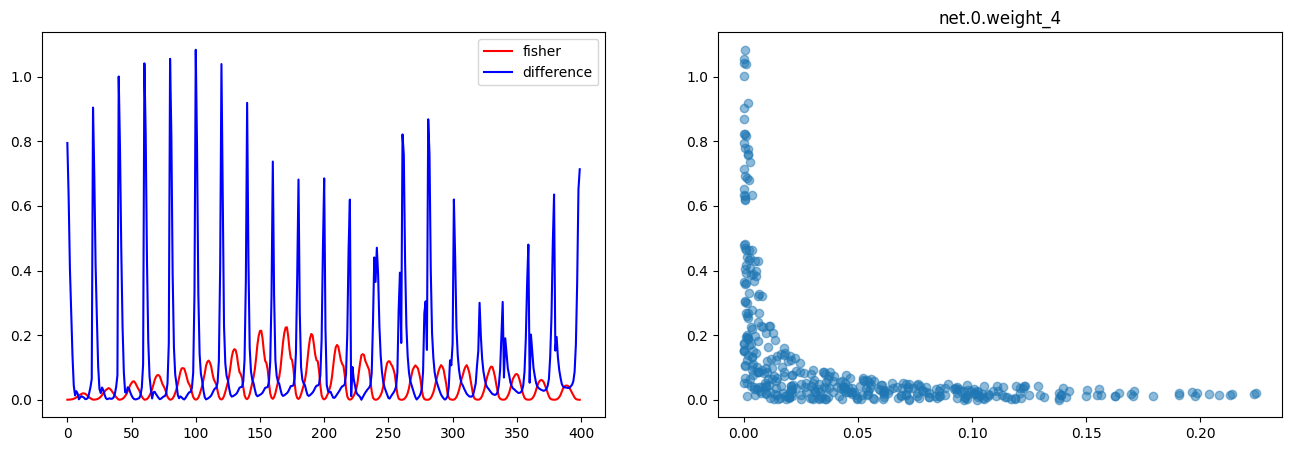

Max fisher is 0.12385 and it's parameter diff is 0.00168
Min Parameter diff is 1.49205 and it's fisher is 0.00004
fisher > parameter diff: 102
fisher <= parameter diff: 298


<Figure size 640x480 with 0 Axes>

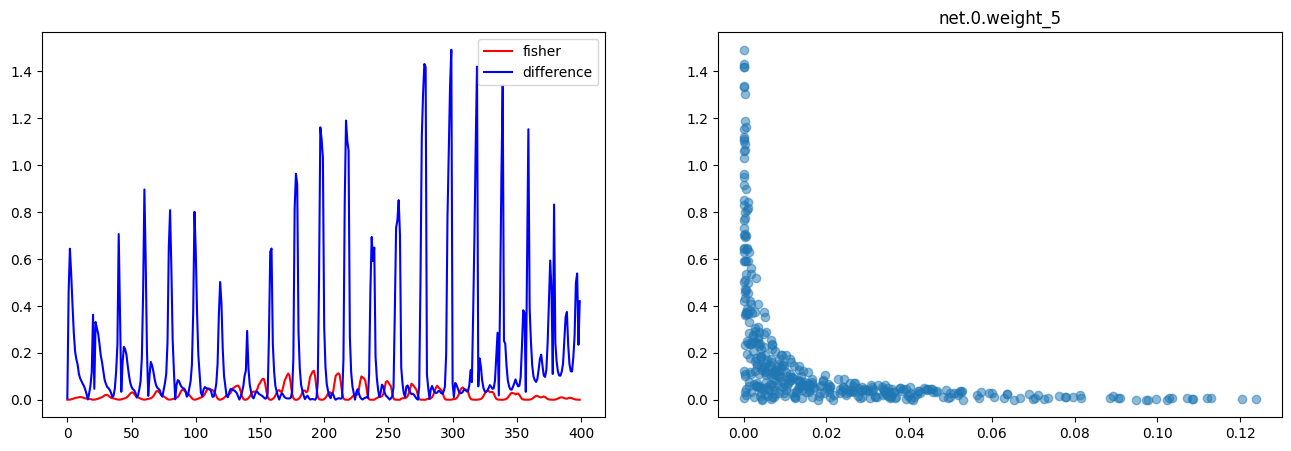

Max fisher is 0.00607 and it's parameter diff is 0.06667
Min Parameter diff is 0.91098 and it's fisher is 0.00066
fisher > parameter diff: 0
fisher <= parameter diff: 400


<Figure size 640x480 with 0 Axes>

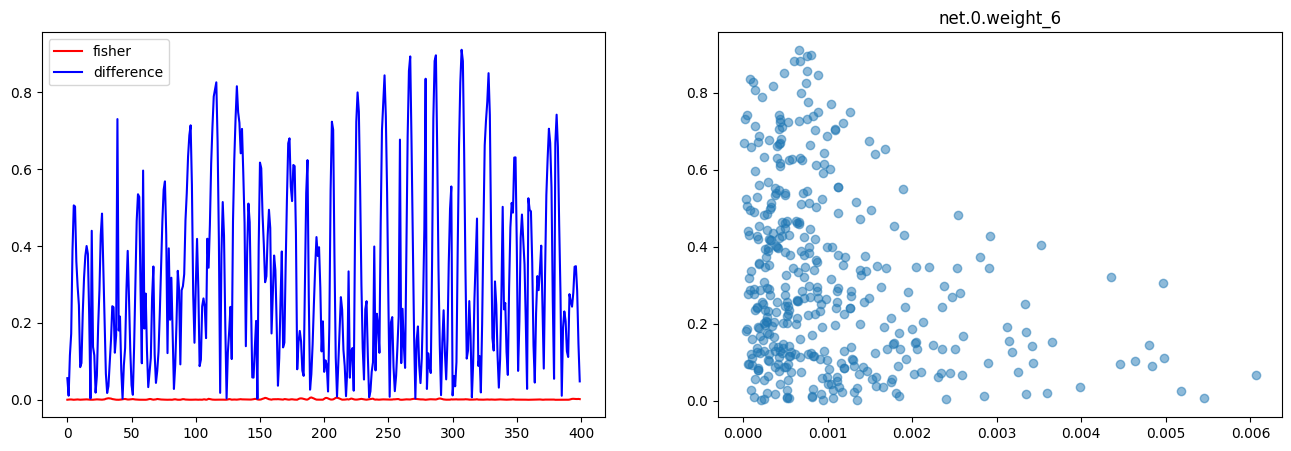

Max fisher is 0.12333 and it's parameter diff is 0.00447
Min Parameter diff is 1.38535 and it's fisher is 0.00018
fisher > parameter diff: 231
fisher <= parameter diff: 169


<Figure size 640x480 with 0 Axes>

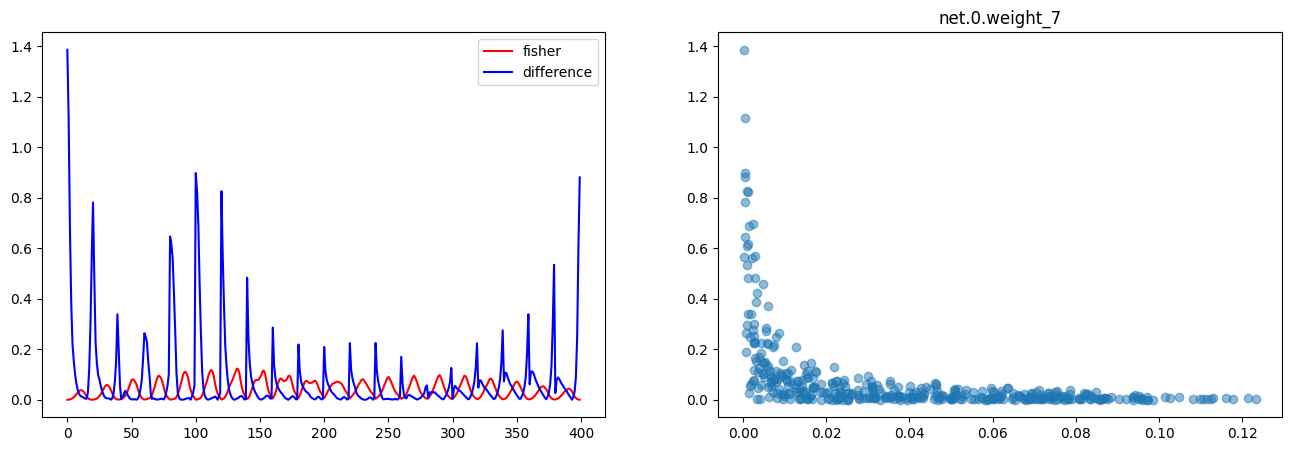

Max fisher is 0.04346 and it's parameter diff is 0.00078
Min Parameter diff is 1.24923 and it's fisher is 0.00029
fisher > parameter diff: 25
fisher <= parameter diff: 375


<Figure size 640x480 with 0 Axes>

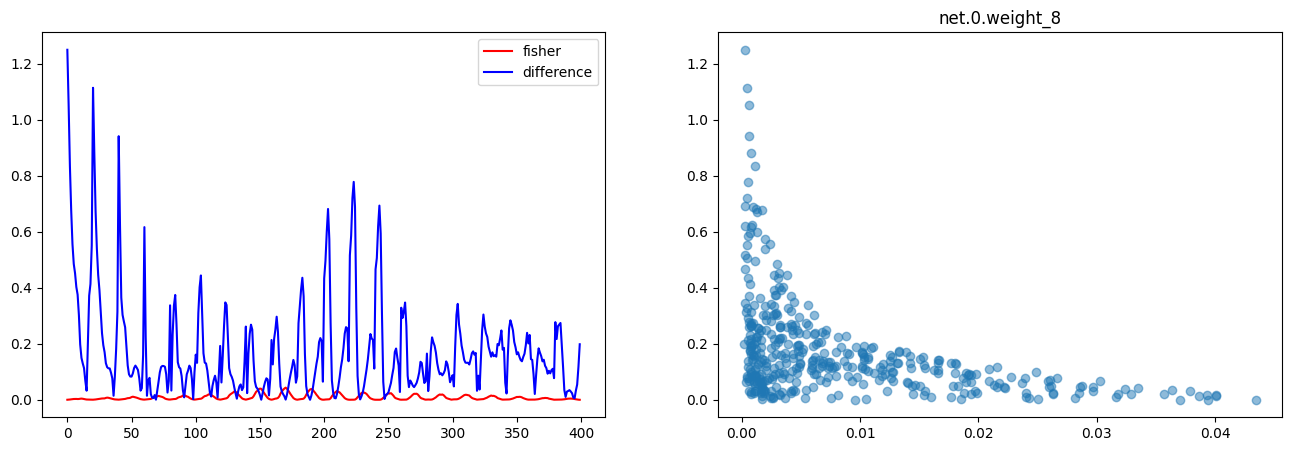

Max fisher is 0.08961 and it's parameter diff is 0.00793
Min Parameter diff is 1.15731 and it's fisher is 0.00038
fisher > parameter diff: 145
fisher <= parameter diff: 255


<Figure size 640x480 with 0 Axes>

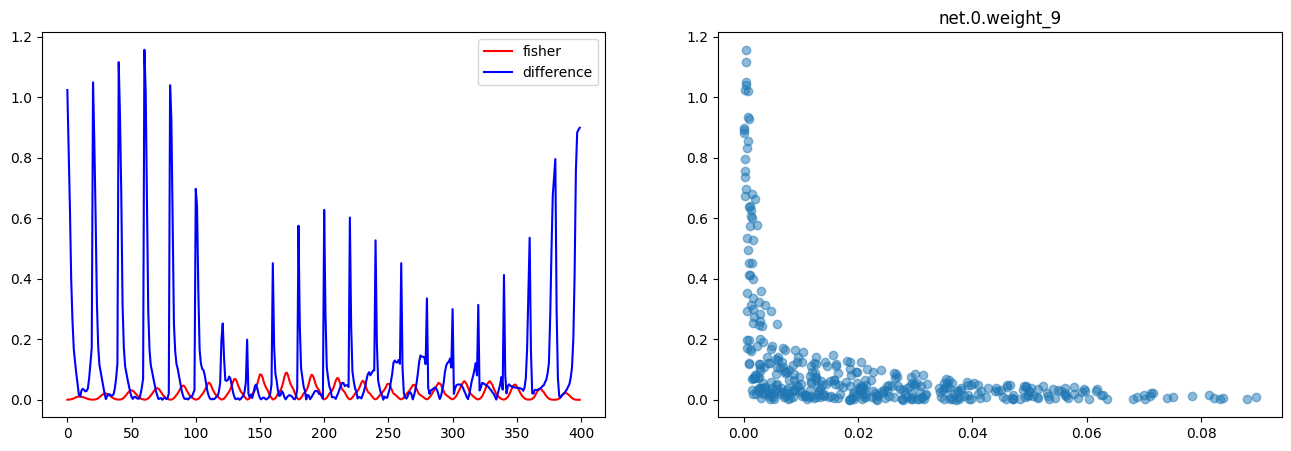


net.0.bias
torch.Size([10])
Max fisher is 0.66388 and it's parameter diff is 0.00890
Min Parameter diff is 0.12807 and it's fisher is 0.00578
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

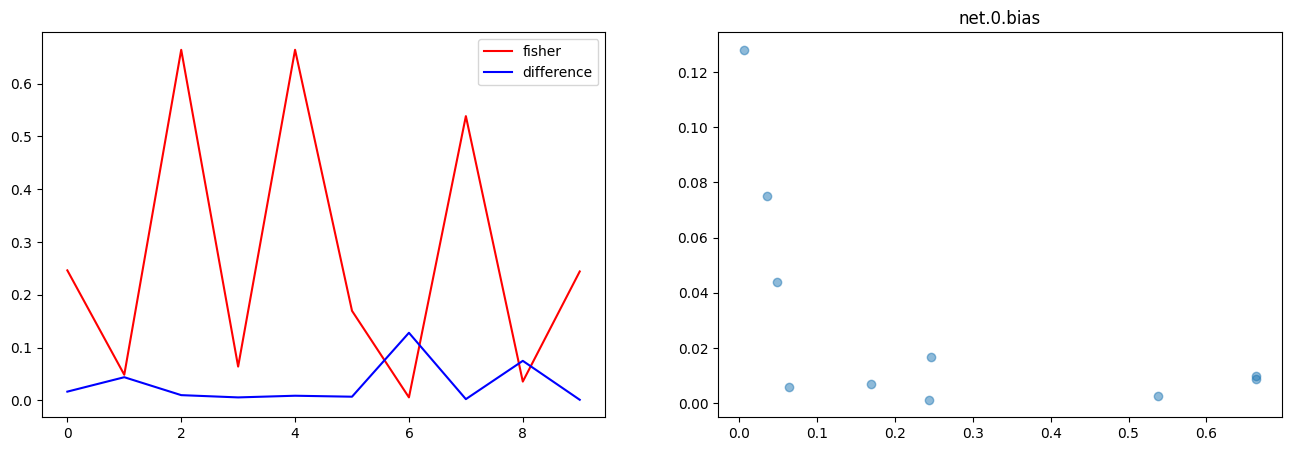


net.4.weight
torch.Size([10, 10])
Max fisher is 40.16833 and it's parameter diff is 0.00074
Min Parameter diff is 0.01595 and it's fisher is 0.38004
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

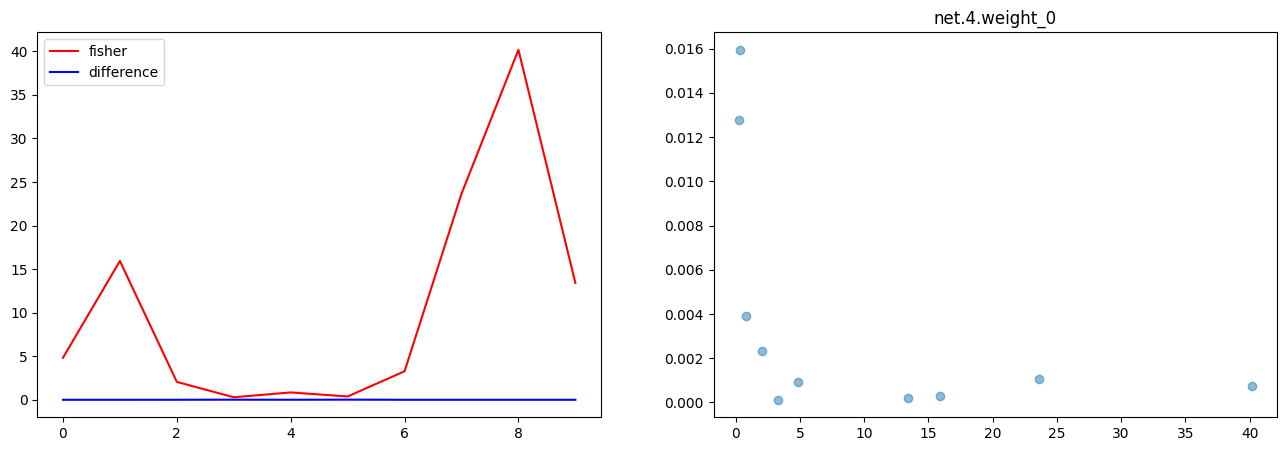

Max fisher is 1.76016 and it's parameter diff is 0.01416
Min Parameter diff is 0.84710 and it's fisher is 0.01523
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

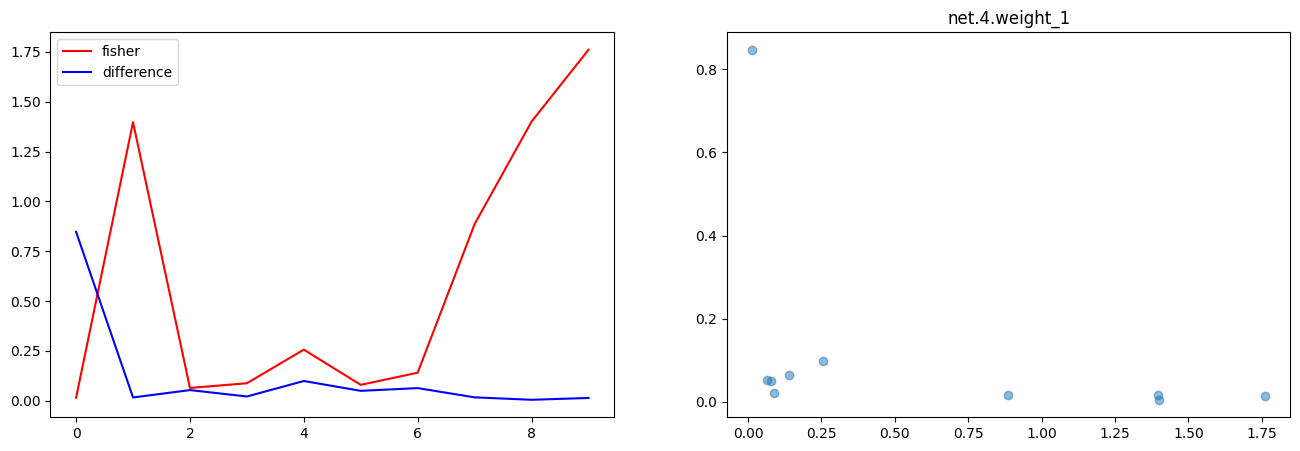

Max fisher is 1.01253 and it's parameter diff is 0.00862
Min Parameter diff is 0.29730 and it's fisher is 0.01716
fisher > parameter diff: 7
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

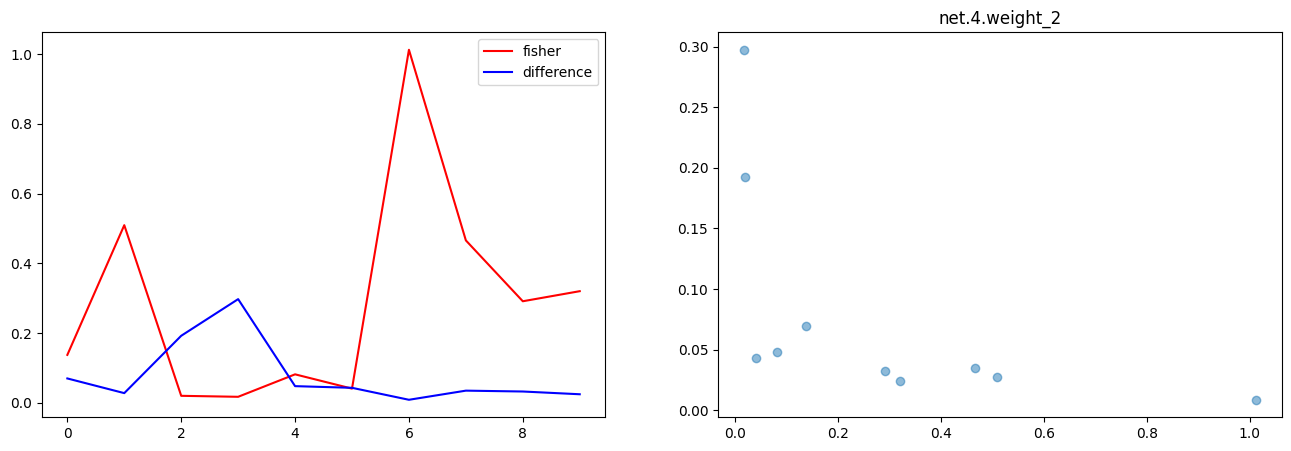

Max fisher is 6.67001 and it's parameter diff is 0.00243
Min Parameter diff is 0.56279 and it's fisher is 0.00722
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

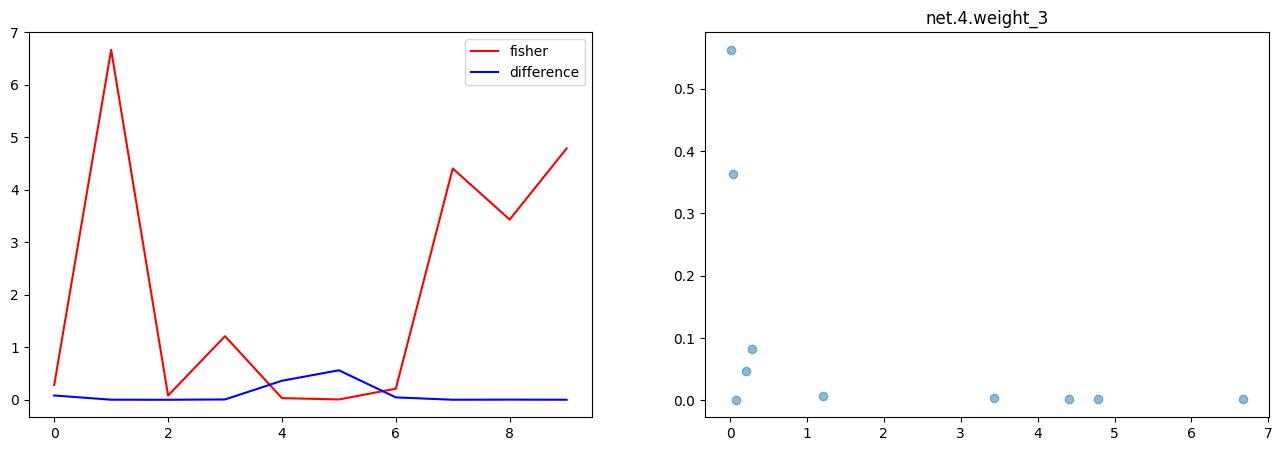

Max fisher is 2.61927 and it's parameter diff is 0.00903
Min Parameter diff is 0.05661 and it's fisher is 0.11341
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

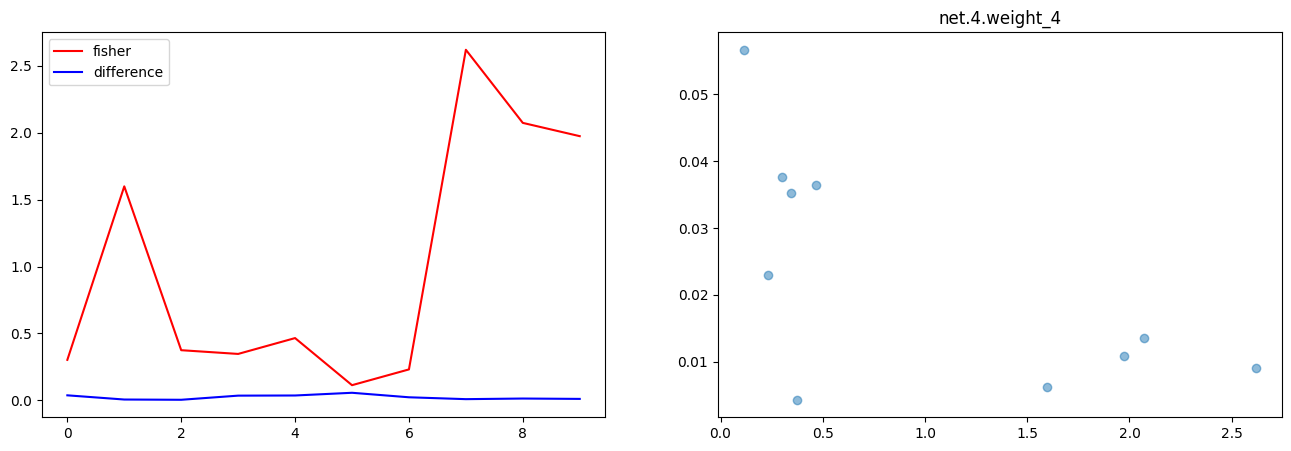

Max fisher is 51.60439 and it's parameter diff is 0.00038
Min Parameter diff is 0.00807 and it's fisher is 2.07852
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

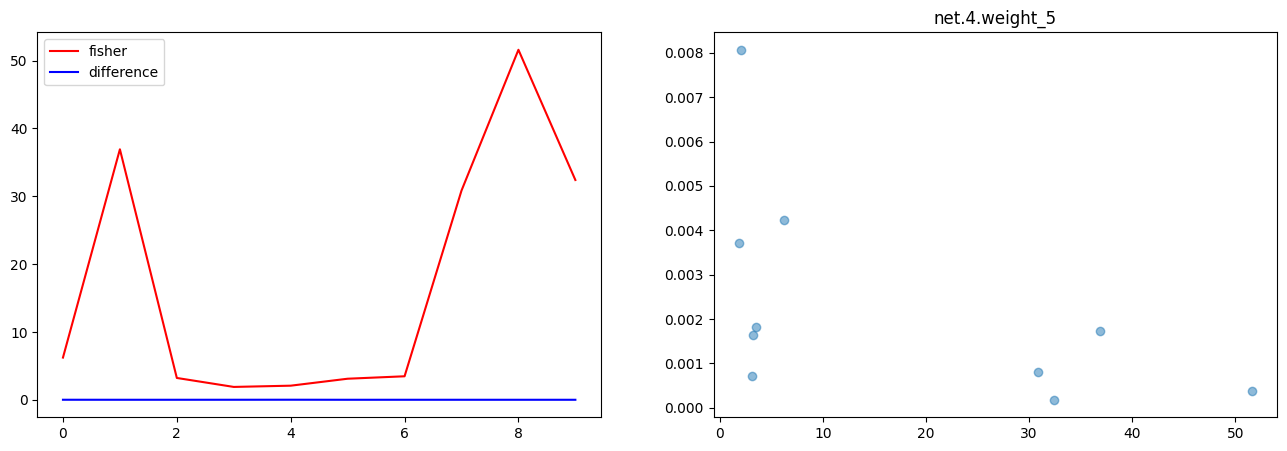

Max fisher is 1.37517 and it's parameter diff is 0.00266
Min Parameter diff is 0.90409 and it's fisher is 0.00584
fisher > parameter diff: 7
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

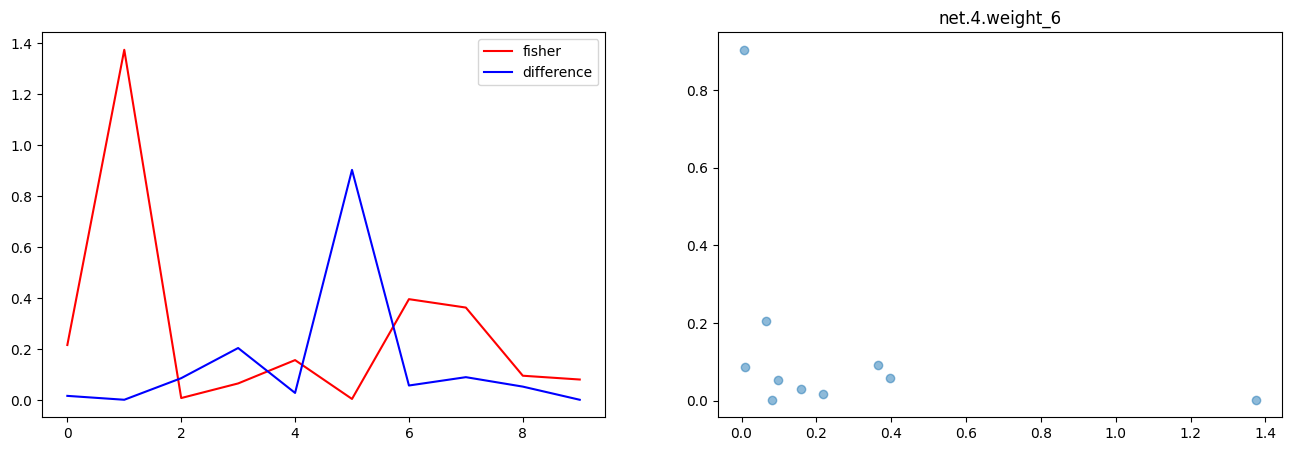

Max fisher is 25.08446 and it's parameter diff is 0.00051
Min Parameter diff is 0.03535 and it's fisher is 0.30154
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

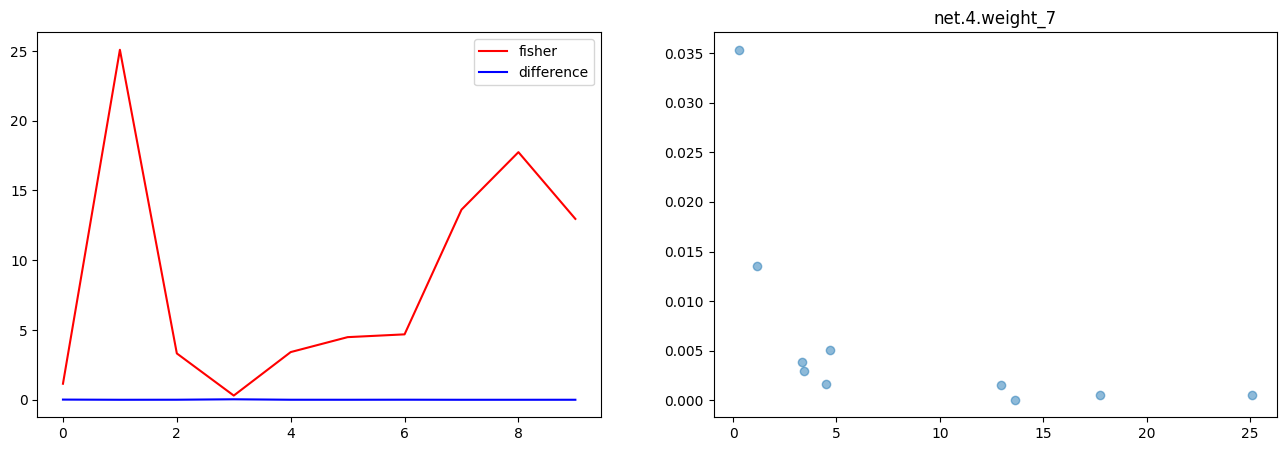

Max fisher is 66.63158 and it's parameter diff is 0.00024
Min Parameter diff is 0.00414 and it's fisher is 3.53770
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

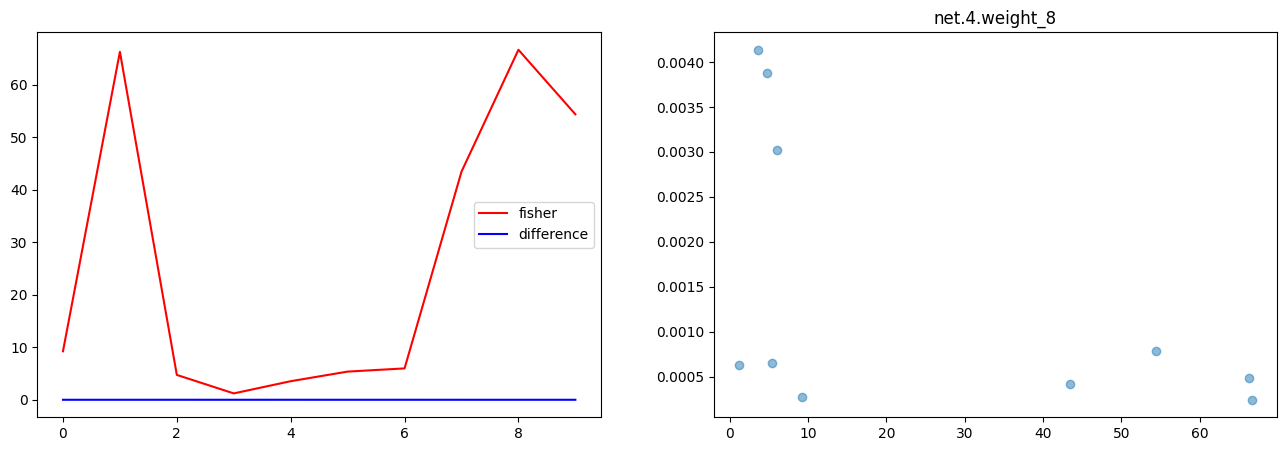

Max fisher is 32.21129 and it's parameter diff is 0.00077
Min Parameter diff is 0.14724 and it's fisher is 0.12759
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

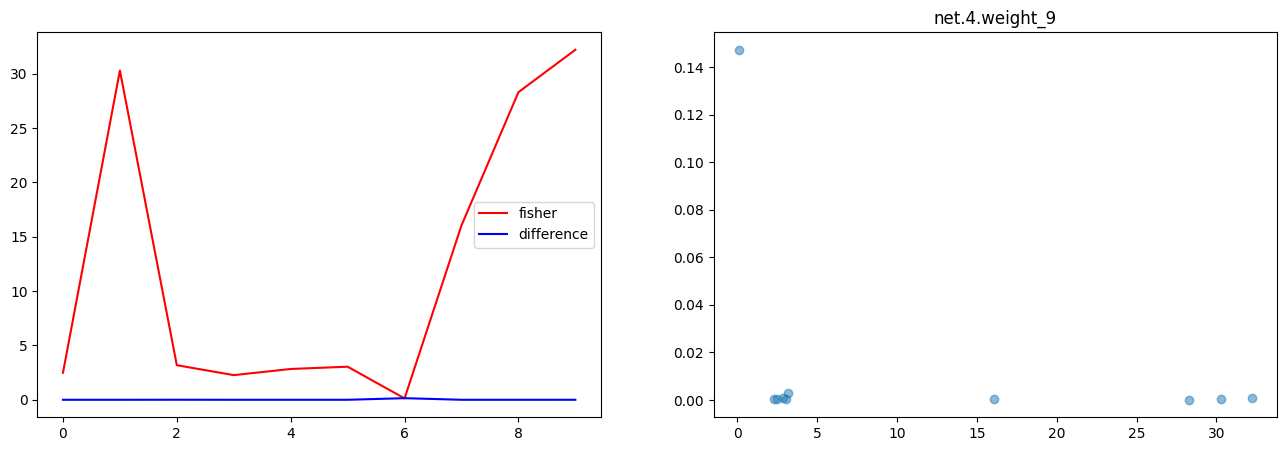


net.4.bias
torch.Size([10])
Max fisher is 0.30848 and it's parameter diff is 0.00117
Min Parameter diff is 0.15153 and it's fisher is 0.00286
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

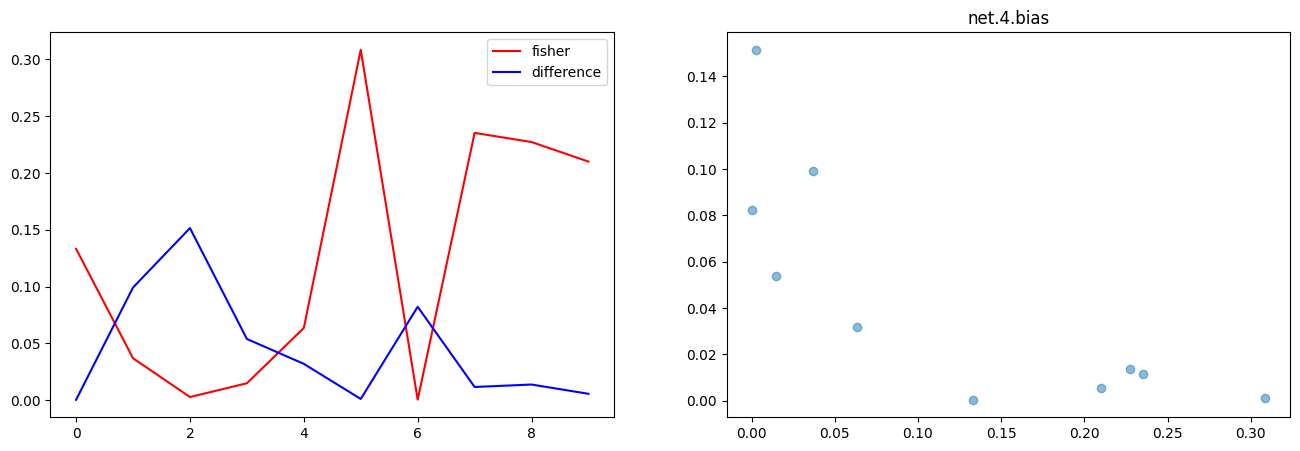

In [113]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i].flatten(), optim_para[0][name][i].flatten(), param[i].flatten(), f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [114]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_19_11_49
